<a href="https://colab.research.google.com/github/ymuto0302/base1_2021/blob/main/GIS2_pop_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用(2)：「地図で見る統計(統計GIS)」を用いた人口密度分布の可視化

## [目標] 人口密度の可視化
政府統計の総合窓口(e-Stat)では「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis が提供されており，国勢調査の結果等が公開されている。

ここで提供されるデータを元に「人口密度の可視化」を試みよう。

---
### Shape file の入手 (真面目な手順)
「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis へアクセスする。

「境界データダウンロード → 小地域 → 国勢調査 → 2015年 → 小地域（町丁・字等別）」と順次，進む。

一気に飛ぶには下記の URL にアクセスする。

https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=A&toukeiCode=00200521&toukeiYear=2015&serveyId=A002005212015

すると，下記のページへ到達する。

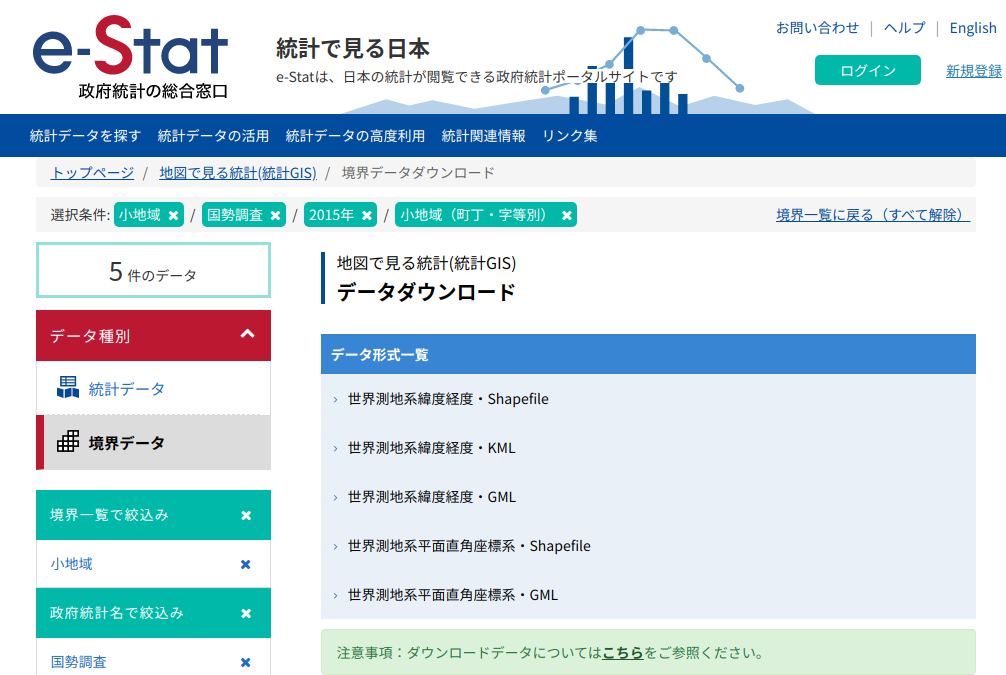



ここで「**世界測地系緯度経度・Shapefile**」を選択した後，自分の関心がある地域の shape file を入手する。

shape file に含まれるデータの詳細は「平成27年国勢調査町丁・字等別境界データ　データベース定義書」を参照すること。

https://www.e-stat.go.jp/gis/statmap-search/data?datatype=2&serveyId=A002005212015&downloadType=1

---
### (準備) geopandas のインストール

In [1]:
!pip install geopandas

### (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
### 人口密度の可視化：福岡県全域を例として
下記のページから福岡県全域の shape file を入手する。

https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=40&coordSys=1&format=shape&downloadType=5

ダウンロードしたファイルは zip 形式であるため，適当なディレクトリに展開する。


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
path = r'/content/drive/My Drive/BASE/GeoData/e-stat/Fukuoka/h27ka40.shp' # 福岡県
fukuoka = gpd.read_file(path)

読み込まれたデータには，「平成27年国勢調査町丁・字等別境界データ　データベース定義書」にて定義された項目（列）である
KEY_CODE, PREF, PREF_NAME, CITY_NAME, GST_NAME, AREA, JINKO 等が含まれる。

In [4]:
#読み込んだデータの先頭を表示（確認）
fukuoka.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry
0,40,40,202,000000,福岡県,大牟田市,None,None,8101,1729.630,254.400,6725,6724,40,福岡県,None,大牟田市,None,0000,-,00,202000000,None,None,D1,43,204,None,None,0,0,0,130.45376,33.00534,0000-00,"POLYGON ((130.45372 33.00497, 130.45365 33.004..."
1,40,40,202,000000,福岡県,大牟田市,None,None,8101,11782.225,433.670,6726,6725,40,福岡県,None,大牟田市,None,0000,-,00,202000000,None,None,D1,43,204,None,None,0,0,0,130.44743,33.00582,0000-00,"POLYGON ((130.44712 33.00648, 130.44746 33.006..."
2,40,40,202,000000,福岡県,大牟田市,None,None,8101,2401.786,316.007,6727,6726,40,福岡県,None,大牟田市,None,0000,-,00,202000000,None,None,D1,43,204,None,None,0,0,0,130.43725,33.00599,0000-00,"POLYGON ((130.43668 33.00625, 130.43807 33.005..."
3,401010010,40,101,001000,福岡県,門司区,青葉台,None,8101,101577.058,1474.768,6411,6410,40,福岡県,None,北九州市,門司区,0010,-,00,101001000,1010010,M,None,None,None,None,青葉台,19,256,103,130.92068,33.88516,0010-00,"POLYGON ((130.92331 33.88419, 130.92313 33.883..."
4,401010020,40,101,002000,福岡県,門司区,大字伊川,None,8101,4699014.636,11449.527,4686,4685,40,福岡県,None,北九州市,門司区,0020,-,00,101002000,1010020,M,None,None,None,None,大字伊川,20,837,373,130.97255,33.91148,0020-00,"POLYGON ((130.96399 33.90387, 130.96402 33.903..."


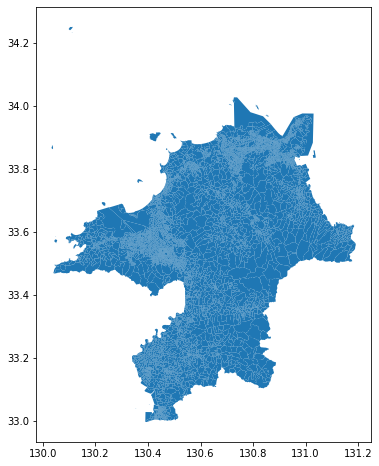

In [5]:
# geopndas の plot 機能を用いた描画
fukuoka.plot(figsize=(16, 8))

上記の地図を見ると海岸線が不自然である。（例えば北九州市や福岡市の沖を見て欲しい）

これはデータ中に「海面」を含むためである。

「海面」を削除するには「分類コード (HCODE)」を見ればよい。

**分類コード (HCODE) の値：**
- 「8101」：町丁・字等
- 「8154」：水面調査区

値 8154 が意味する「水面調査区」とは一般に「海面」を指しており，人口密度を求める観点から不要だから，次のコードにより削除する。
（可視化する際に邪魔になる，というのも理由のひとつである）

In [6]:
fukuoka = fukuoka[fukuoka['HCODE'] != 8154]

定義書に従うと，項目「JINKO」は人口総数（単位：人），項目「AREA」は面積（単位：平方メートル）である。

故に，人口総数(JINKO) ÷ 面積(AREA)により人口密度[人/m2]を求めることができる。

ここでは，人口密度 (POP_DENSITY) を新たな項目として GeoDataframe へ付与する。

In [8]:
# 人口密度を求める
fukuoka['POP_DENSITY'] = fukuoka['JINKO'] / fukuoka['AREA'].copy()

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


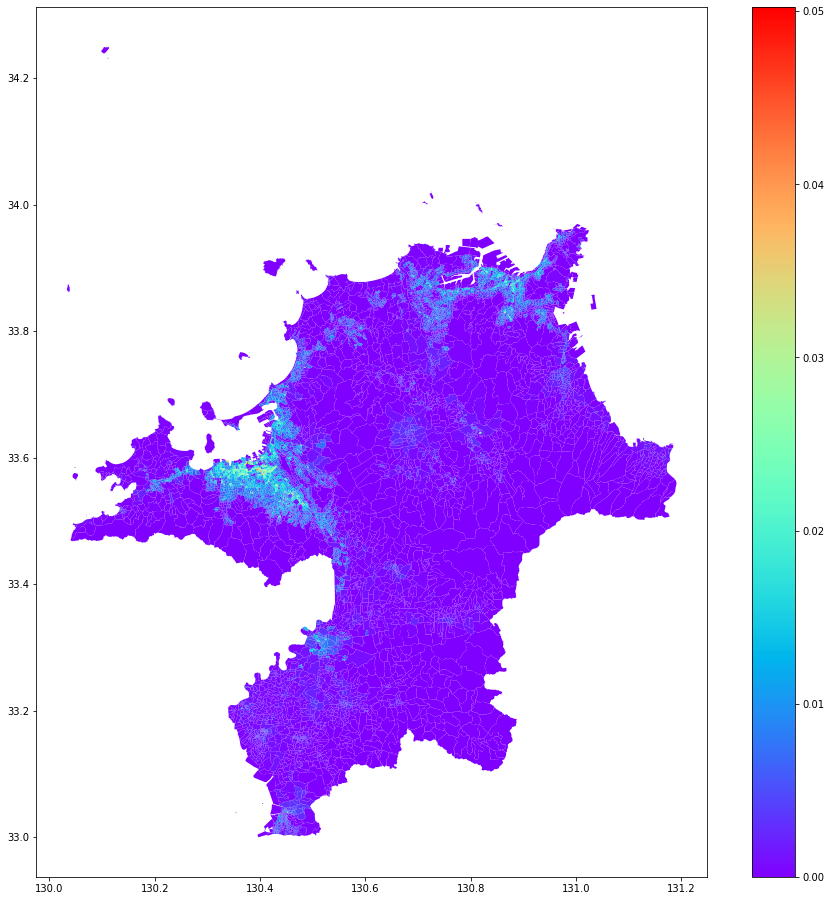

In [9]:
# 可視化
fig, ax = plt.subplots(1, figsize=(16, 16))
fukuoka.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True) # cmap='hot'

福岡県を俯瞰すると，北九州市，福岡市，鳥栖市，久留米市，鳥栖市，大牟田市の人口密度が高いことが分かった。

### データ取得から人口密度の可視化までのプロセス
ここまでの手順をまとめると，次のようになる。

1. 注目する地域の shape データを e-stat からダウンロード
1. 海面（水面調査区）の削除
1. 人口密度を求める（例名：POP_DENSITY)
1. 可視化

### 北九州市へ絞り込む
以下では北九州市に絞り込み，改めて人口密度分布を見てみよう。

北九州市は政令指定都市であるため，CITY_NAME 列には区の名称が格納されている。北九州市のみを抽出するには GST_NAME 列を利用すればよい。

(メモ) 若干，紛らわしいが，「平成27年国勢調査町丁・字等別境界データ　データベース定義書」よると，次のように各項目が定義されている。

- CITY_NAME : 区町村名 （CSS_NAME; ない場合は GST_NAME)
- CSS_NAME : 区町村名
- GST_NAME : 郡市・特別区・政令指定都市名

北九州市の場合，「区」があるため CITY_NAME には「小倉北区」等が入る。一方，山口県には政令指定都市がないため，CITY_NAME と GST_NAME が一致する。



In [10]:
# GST_NAME を利用して，北九州市のみに絞り込む
kitakyu = fukuoka[fukuoka.GST_NAME=='北九州市'].copy() # 元の geodata へ影響を及ぼさないよう，コピー
kitakyu.reset_index(inplace=True)

In [11]:
kitakyu.head()

,index,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,PERIMETER,H27KAxx_,H27KAxx_ID,KEN,KEN_NAME,SITYO_NAME,GST_NAME,CSS_NAME,KIHON1,DUMMY1,KIHON2,KEYCODE1,KEYCODE2,AREA_MAX_F,KIGO_D,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry,POP_DENSITY
0,3,401010010,40,101,001000,福岡県,門司区,青葉台,None,8101,101577.058,1474.768,6411,6410,40,福岡県,None,北九州市,門司区,0010,-,00,101001000,1010010,M,None,None,None,None,青葉台,19,256,103,130.92068,33.88516,0010-00,"POLYGON ((130.92331 33.88419, 130.92313 33.883...",0.002520
1,4,401010020,40,101,002000,福岡県,門司区,大字伊川,None,8101,4699014.636,11449.527,4686,4685,40,福岡県,None,北九州市,門司区,0020,-,00,101002000,1010020,M,None,None,None,None,大字伊川,20,837,373,130.97255,33.91148,0020-00,"POLYGON ((130.96399 33.90387, 130.96402 33.903...",0.000178
2,5,401010030,40,101,003000,福岡県,門司区,泉ヶ丘,None,8101,82882.547,1262.830,6848,6847,40,福岡県,None,北九州市,門司区,0030,-,00,101003000,1010030,M,None,None,None,None,泉ヶ丘,14,851,351,130.93510,33.89115,0030-00,"POLYGON ((130.93498 33.88987, 130.93465 33.889...",0.010268
3,6,40101004001,40,101,004001,福岡県,門司区,稲積１丁目,None,8101,73188.211,1367.878,3028,3027,40,福岡県,None,北九州市,門司区,0040,-,01,101004001,101004001,M,None,None,None,None,稲積１丁目,12,873,341,130.92773,33.88900,0040-01,"POLYGON ((130.92924 33.88845, 130.92938 33.888...",0.011928
4,7,40101004002,40,101,004002,福岡県,門司区,稲積２丁目,None,8101,68074.736,1040.949,4684,4683,40,福岡県,None,北九州市,門司区,0040,-,02,101004002,101004002,M,None,None,None,None,稲積２丁目,13,717,277,130.92894,33.88631,0040-02,"POLYGON ((130.92965 33.88525, 130.92897 33.884...",0.010533


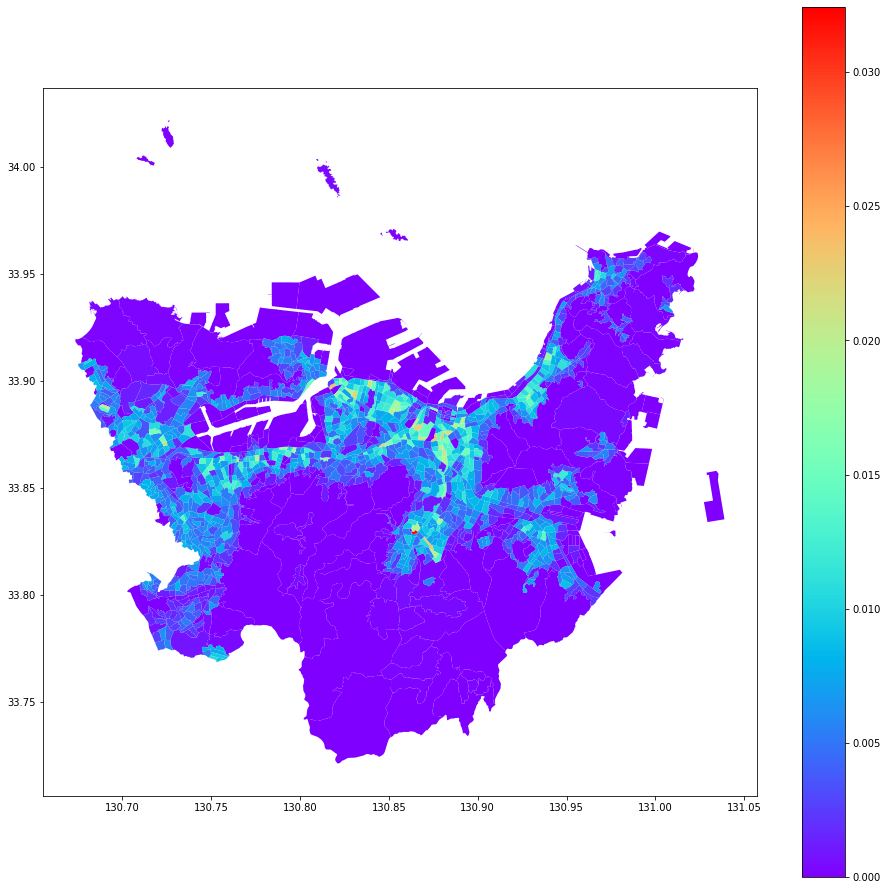

In [12]:
# 可視化
fig, ax = plt.subplots(1, figsize=(16, 16))
kitakyu.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True)

---
### Folium を使ってみる
geopandas + shape file を用いると人口密度を可視化できるものの，地名等が表示されないため，解釈が困難となる。
そこで Folium というライブラリを使ってみよう。

Folium とは，leaflet.js というJavascriptの地図ライブラリをPythonで使えるよう，ライブラリ化したものである。

以下に Folium を用いて地図を描画するコードを示す。

In [13]:
import folium
from folium.plugins import HeatMap

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 小倉駅を中心とした
center_lat=33.886968
center_lon=130.882576
zoom = 4
map = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

map # 表示

#### Folium 上で人口密度分布を可視化する方法
Folum にて各地域ごとの人口密度を反映するには次の２つの方法がある。
- shape データを geojson 形式へ変換し，メッシュ状で表現する
- **Folium のプラグインである HeatMap を用いてヒートマップを作成し，地図に重ねる。**

以下では後者の HeatMap を用いる。

手順は以下のとおりである。
1. 各ポリゴンの中心座標を求め，人口密度を値（高さ）としてヒートマップデータを作る。
1. Folium を用いて地図を作る。
2. ヒートマップデータを地図に加える。


最初に「ポリゴンの中心座標」を得る方法を確認しておく。

In [14]:
point = kitakyu['geometry'][0].centroid # polygon の中心座標を得る
print(point) # 経度，緯度の順番で位置情報が格納されている
longitude, latitude = point.x, point.y # 経度=longitude, 緯度=latitude
print(longitude, latitude)

POINT (130.9208269850267 33.88499303554601)
130.92082698502665 33.88499303554601


以下に人口密度分布をヒートマップとして表現するコードを示す。

In [15]:
import folium
from folium.plugins import HeatMap

# ヒートマップ用のデータを構築する
heatmap_data = []
for i in range(len(kitakyu)):
    point = kitakyu['geometry'][i].centroid # 各 geometry の中心座標を取得する
    longitude, latitude = point.x, point.y # 経度(longtitude)，緯度(latitude) を取り出す

    # ヒートマップに渡すデータは第１引数が latitude(緯度)，第２引数が longitude(経度)，第３引数が値の高さ
    # 特に latitude, longitude の順番に注意！
    heatmap_data.append([latitude, longitude, kitakyu['POP_DENSITY'][i]])

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 小倉駅を中心とした
center_lat=33.886968
center_lon=130.882576
zoom = 12 #4
map = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

# ヒートマップデータを地図に重ねる
HeatMap(heatmap_data, radius=30, blur=40).add_to(map)

map # 表示

## 課題：山口県および宇部市の人口密度を可視化する
下記のページから山口県全域の shape file を入手できる。

https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=35&coordSys=1&format=shape&downloadType=5

上記の手順に従い，山口県および宇部市の人口密度分布を可視化せよ。

---
# オープンデータ + Folium
位置情報データは常に shape ファイルで与えられるとは限らない。

以下ではスターバックスの店舗データを例として，オープンデータから店舗位置を取得し，Folium の地図に重ねる話題を提供する

## データセット：Starbucks Locations Worldwide
世界中の Starbucks の店舗情報(25,600店！)を収集したファイルが Kaggle にて公開されている。

Starbucks Locations Worldwide  
https://www.kaggle.com/starbucks/store-locations

ただし，少し古いデータゆえ，宇部店は含まれない。
また，位置情報（緯度・経度の情報）の精度が粗い点も気になる。

In [16]:
import pandas as pd

# データの読み込み
path = r'/content/drive/My Drive/BASE/GeoData/Starbucks/directory.csv'
starbucks = pd.read_csv(path)

In [17]:
# データの先頭を覗き見る
starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [18]:
# 日本国内の店舗情報のみを抽出
starbucks_jp = starbucks[starbucks['Country'].isin(['JP'])].copy()

In [19]:
# データの先頭を覗き見る
starbucks_jp.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
6739,Starbucks,26291-235224,AEON MALL Asahikawa Eki-mae,Joint Venture,7-2-5 Miyashita-dori,Asahikawa,1,JP,070-0030,NaN,GMT+09:00 Asia/Tokyo,142.36,43.76
6740,Starbucks,31568-111246,Asahikawa Medical College Hospital,Joint Venture,1-1 Midorigaoka-higashi 2jo 1,Asahikawa,1,JP,078-8510,NaN,GMT+09:00 Asia/Tokyo,142.38,43.73
6741,Starbucks,47076-251782,Asahikawa Toko,Company Owned,6-207-5 13jo Higashimitsu,Asahikawa,1,JP,078-8353,NaN,GMT+09:00 Asia/Tokyo,142.41,43.74
6742,Starbucks,30540-94875,AEON MALL Asahikawa-nishi,Joint Venture,2161-3 23-chome Midorimachi,Asahikawa,1,JP,070-0823,NaN,GMT+09:00 Asia/Tokyo,142.32,43.79
6743,Starbucks,15352-156247,New Chitose Airport,Joint Venture,Bibi Chitose,Chitose,1,JP,066-0012,NaN,GMT+09:00 Asia/Tokyo,141.68,42.79


## 位置情報の抽出 ＆ Folium のマーカー利用

In [20]:
# 位置情報のみを取り出し，リスト points へ格納
points = []
for idx, data in starbucks_jp.iterrows():
    points.append([data['Longitude'], data['Latitude']])

points[:5] # 先頭５件を確認

[[142.36, 43.76],
 [142.38, 43.73],
 [142.41, 43.74],
 [142.32, 43.79],
 [141.68, 42.79]]

スターバックの店舗がある位置にマーカー (marker) を設定し，Folium の地図に重ねる

In [21]:
import folium

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 東京駅の所在地を中心とした
center_lat=35.681236
center_lon=139.767125
zoom = 4
m = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

# 地図にマーカーを追加
for point in points:
    latitude, longitude = point
    folium.Marker(location=[longitude, latitude]).add_to(m) # 座標(location)は経度(longitude)，緯度(latitude)の順

m # 表示

---
## (参考) 東京都の人口分布
もっとも人口の多い東京都の人口分布を可視化する。

予め「東京都全域」の shape data を入手しておくことが前提である。

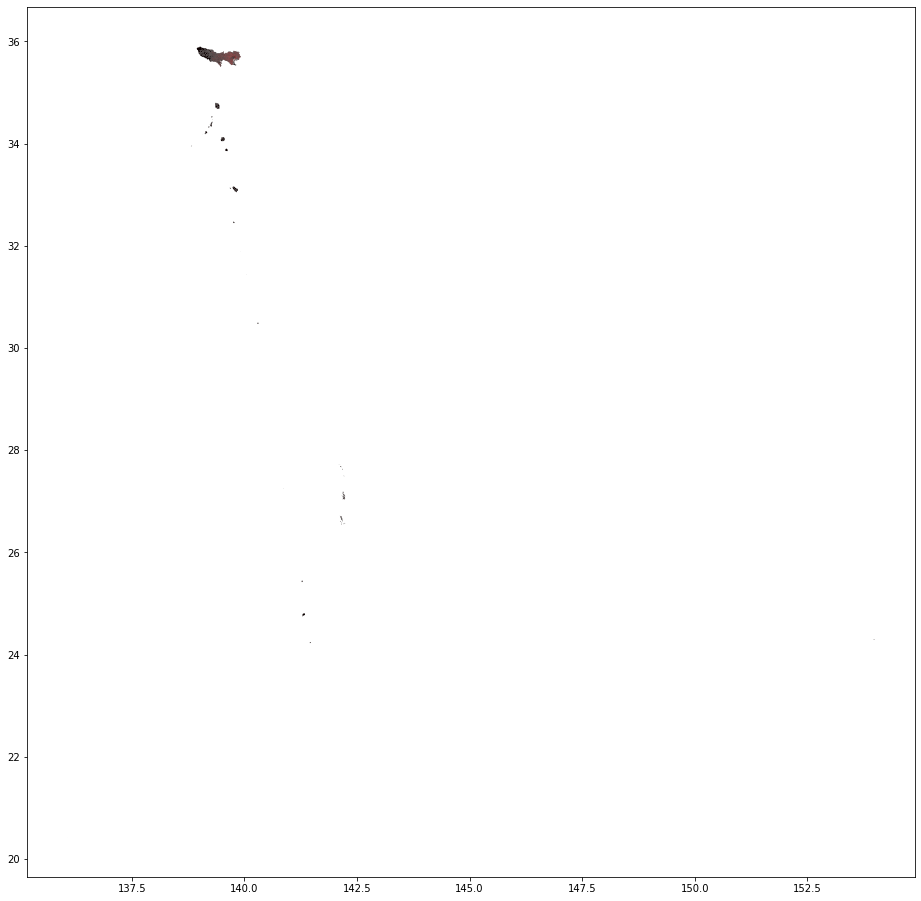

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
tokyo = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Tokyo/h27ka13.shp')
tokyo = tokyo[tokyo['HCODE'] != 8154] # 海を除く

# 人口密度を求める
tokyo['POP_DENSITY'] = tokyo['JINKO'] / tokyo['AREA']

# 可視化
fig, ax = plt.subplots(1, figsize=(16, 16))
tokyo.plot(ax=ax, column='POP_DENSITY', cmap='hot')

### 東京都が小さくなってしまった！！
実は，伊豆諸島と小笠原諸島は東京都の一部であり，東京都の面積がばかでかいのが原因である。

上記の出力から判断するに，伊豆諸島と小笠原諸島を除くには「北緯 >= 35度以上」に限定すればよさそうである。

読み込んだ GeoDataframe において「X_CODE」が経度，「Y_CODE」が緯度に当たることから，これを利用する。

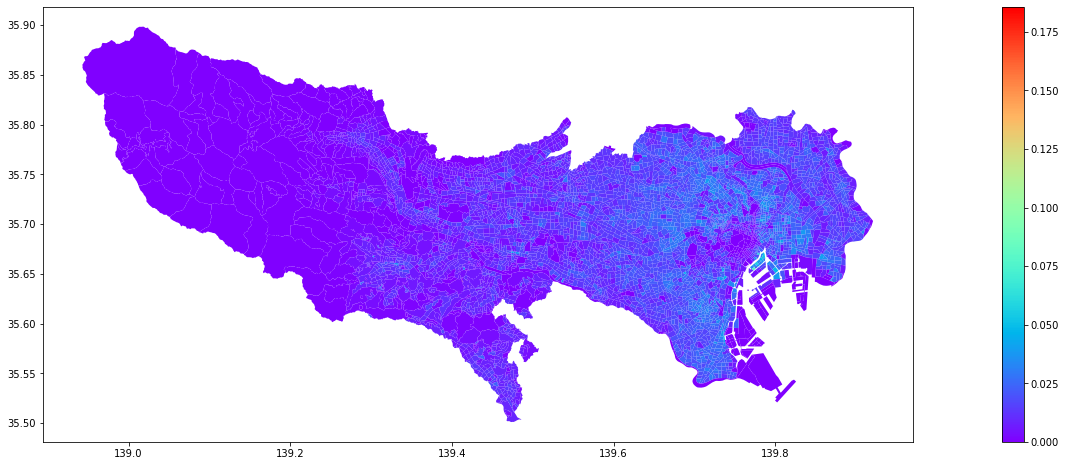

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
tokyo = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Tokyo/h27ka13.shp')
tokyo = tokyo[tokyo['HCODE'] != 8154] # 海を除く
tokyo = tokyo[tokyo['Y_CODE'] >= 35.0] # 島しょ部を除く <<<==== It's NEW !

# 人口密度を求める
tokyo['POP_DENSITY'] = tokyo['JINKO'] / tokyo['AREA']

# 可視化
fig, ax = plt.subplots(1, figsize=(32, 8))
tokyo.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True)